In [1]:
from time import time, localtime
import numpy as np
from utils import plot_graph
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras import losses, metrics, optimizers
import random
import pandas as pd
import sys
import matplotlib.pyplot as plt
import nest_asyncio
from pathlib import Path
from checkpoint_manager import FileCheckpointManager
import tensorflow_addons as tfa
nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)


2022-12-03 16:12:43.113497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 16:12:43.426984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 16:12:43.427018: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-03 16:12:43.480048: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-03 16:12:44.849589: W tensorflow/stream_executor/pla

In [2]:
def train_test_split(df, frac=0.2):
    selected = df['flow_id'].drop_duplicates().sample(frac=frac)
    test = df[df['flow_id'].isin(selected)]
    train = df[~df['flow_id'].isin(selected)]
    return train, test

Lựa chọn model <br>
Thay models.<Ten_model>

In [3]:
from models.CNN_2D import create_keras_model


Thay đổi các siêu tham số trong cell dưới <br>
**experiment_name:** Tên bộ dữ liệu được sử dụng, <Tên dữ liệu>_<Số byte sử dụng> <br>
**method:** Mô hình sử dụng <br>
**client_lr, server_lr:** Learning rate của client và server, khi fine tune bắt đầu từ 1 và giảm dần xuống 3e-4 <br>
**NUM_ROUNDS:** Số vòng lặp (Bắt đầu từ 1 và tăng dần lên 3000 nếu mô hình chưa hội tụ - 1/100/200/300/400/500/.../3000) <Br>
**BATCH_SIZE:** Kích thước batch (Bắt đầu từ 8 và tăng dần lên 64) 8/16/32/64 <br>
**split:** Để nguyên là 5

byte_number (string): Cac byte cua packet, bao gom 10, 32, 64, 128, 256, 512, 1024, 1460

In [4]:
byte_number = "512"


In [5]:
experiment_name = "GQUIC_" + byte_number
method = "nonFL_CNN_2D"
client_lr = 3e-4
NUM_ROUNDS = 200
BATCH_SIZE = 32


In [6]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method
output_dir = this_dir / "sdn_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


In [7]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


In [8]:
def most_frequent(List):
    return max(set(List), key=List.count)


### Đọc dữ liệu

In [9]:
train_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Train/GQUIC_data_' + byte_number + '.feather'
test_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Test//GQUIC_test_' + byte_number + '.feather'
data = pd.read_feather(train_dir)
test = pd.read_feather(test_dir)


In [10]:
data, val = train_test_split(data,frac=0.2)

In [11]:
result = test.groupby('flow_id')['Label'].apply(list).to_dict()
flow_label = []
for flow in result:
    flow_label.append(most_frequent(result[flow]))

In [12]:
result = data.groupby('flow_id')['Label'].apply(list).to_dict()
train_label = []
for flow in result:
    train_label.append(most_frequent(result[flow]))

In [13]:
result = val.groupby('flow_id')['Label'].apply(list).to_dict()
val_label = []
for flow in result:
    val_label.append(most_frequent(result[flow]))

In [14]:
flow_label = np.array(flow_label)
train_label = np.array(train_label)
val_label = np.array(val_label)

In [15]:
true_test = test.drop('flow_id', axis=1)
true_data = data.drop('flow_id', axis=1)
true_val = val.drop('flow_id',axis=1)

In [16]:
NUM_FEATURE = len(true_test.columns)-1
NUM_CLASSES = len(np.unique(true_test['Label']))
print(NUM_FEATURE, NUM_CLASSES)

512 4


In [17]:
x_test = true_test.drop('Label', axis=1).to_numpy()/255
x_train = true_data.drop(['Label'], axis=1).to_numpy()/255
x_val = true_val.drop(['Label'],axis=1).to_numpy()/255

In [18]:
x_train = x_train.reshape(-1,20,NUM_FEATURE)
x_test = x_test.reshape(-1,20,NUM_FEATURE)
x_val = x_val.reshape(-1,20,NUM_FEATURE)

In [19]:
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

In [20]:
# def sklearn_to_df(sklearn_dataset):
#     df = pd.DataFrame(sklearn_dataset.data,
#                       columns=sklearn_dataset.feature_names)
#     df['Label'] = pd.Series(sklearn_dataset.Label)
#     return df


In [21]:
# from sklearn import datasets
# df = sklearn_to_df(datasets.load_iris())


In [22]:
# train_data = train_data[0].concatenate(train_data[1])
# val_data = val_data[0].concatenate(val_data[1])


### Model Definition

In [23]:
model = create_keras_model(NUM_FEATURE, NUM_CLASSES)
model.summary()

2022-12-03 16:13:42.823756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-03 16:13:42.823809: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-03 16:13:42.824007: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (onos-virtual-machine): /proc/driver/nvidia/version does not exist
2022-12-03 16:13:42.824886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 512, 32)       832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 512, 32)       25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 256, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 256, 32)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 256, 64)       18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 256, 64)       36928     
                                                        

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=client_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
start = time()
history = model.fit(x_train, train_label, epochs=NUM_ROUNDS, batch_size=BATCH_SIZE,use_multiprocessing=True,shuffle=False,validation_data=(x_val,val_label))
end = time() - start

Epoch 1/200
279/279 [==============================] - 264s 941ms/step - loss: 0.3094 - sparse_categorical_accuracy: 0.8906 - val_loss: 10.5456 - val_sparse_categorical_accuracy: 0.1704
Epoch 2/200
279/279 [==============================] - 264s 948ms/step - loss: 0.3939 - sparse_categorical_accuracy: 0.9073 - val_loss: 8.1916 - val_sparse_categorical_accuracy: 0.3687
Epoch 3/200
279/279 [==============================] - 255s 913ms/step - loss: 0.3490 - sparse_categorical_accuracy: 0.9076 - val_loss: 8.4558 - val_sparse_categorical_accuracy: 0.1551
Epoch 4/200
279/279 [==============================] - 258s 924ms/step - loss: 0.3835 - sparse_categorical_accuracy: 0.8984 - val_loss: 4.5814 - val_sparse_categorical_accuracy: 0.4164
Epoch 5/200
279/279 [==============================] - 258s 926ms/step - loss: 0.3246 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.9877 - val_sparse_categorical_accuracy: 0.4227
Epoch 6/200
279/279 [==============================] - 242s 869ms/step - l

In [25]:
total_time = "Time: {}".format(sec_to_hours(end))
print(total_time)


Time: 8 hours 31 mins 27 seconds


### Evaluation

In [27]:
best_model_accuracy = history.history['sparse_categorical_accuracy'][np.argmin(history.history['loss'])]

In [28]:
_, test_acc = model.evaluate(x_test, flow_label, verbose=2, batch_size=BATCH_SIZE,use_multiprocessing=True)

87/87 - 3s - loss: 0.7900 - sparse_categorical_accuracy: 0.9500 - 3s/epoch - 33ms/step


In [29]:
train_val = str(round(best_model_accuracy*100)) + "_" + str(round(test_acc*100))

In [30]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method / train_val
output_dir = this_dir / "sdn_results" / experiment_name / method / train_val

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [31]:
model.save(model_dir/'model.h5')

In [32]:
with open(output_dir/'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [33]:
text_file = open(output_dir/"time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [34]:
predictions = model.predict(x_test,verbose=2,use_multiprocessing=True,batch_size=BATCH_SIZE)

87/87 - 3s - 3s/epoch - 37ms/step


In [35]:
flow_pred = np.argmax(predictions, axis=-1)

In [36]:
flow_pred

array([1, 1, 1, ..., 2, 2, 2])

In [37]:
flow_label[0]

1

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


classes = []
for c in range(NUM_CLASSES):
    classes.append("Class {}".format(c))
print(classes)
with open(output_dir/'metrics.txt', 'w') as f:
    confusion = confusion_matrix(flow_label, flow_pred)
    print('Confusion Matrix\n', file=f)
    print(confusion, file=f)

    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(flow_label, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(flow_label, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(flow_label, flow_pred, target_names=classes), file=f)
    f.close()


['Class 0', 'Class 1', 'Class 2', 'Class 3']


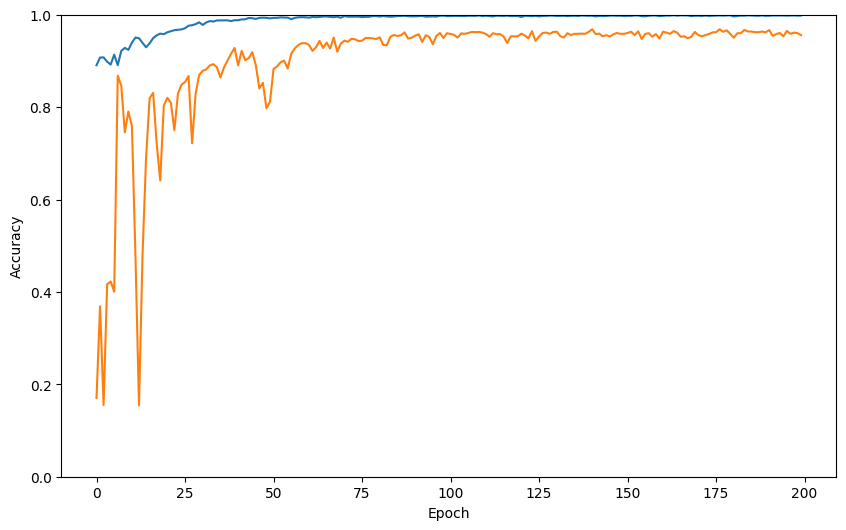

In [39]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.savefig(output_dir / "normal_model_Accuracy.png")

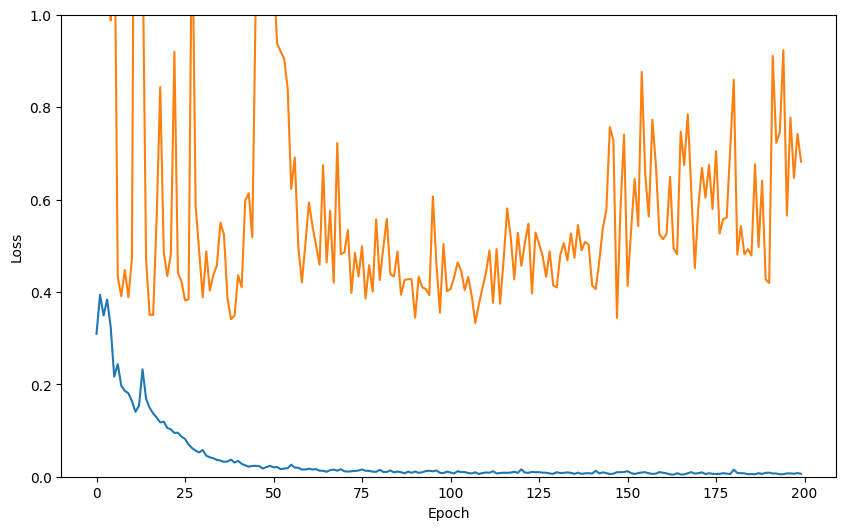

In [40]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.savefig(output_dir / "normal_model_Loss.png")